# Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import IPython.display as ipd
import sklearn as skl
import pandas as pd
from PIL import Image
import seaborn as sns
import sys
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

from torcheval.metrics.metric import Metric
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from torcheval.metrics import MulticlassPrecision
from torcheval.metrics import MulticlassRecall
from torcheval.metrics import MulticlassConfusionMatrix
from torcheval.metrics import MulticlassF1Score

from torcheval.metrics import BinaryAccuracy
from torcheval.metrics import BinaryPrecision
from torcheval.metrics import BinaryRecall
from torcheval.metrics import BinaryConfusionMatrix
from torcheval.metrics import BinaryF1Score

from torcheval.metrics.functional import mean_squared_error

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
gtzan_dir = Path(str(os.environ.get('GTZAN_DIR')))   #C:/VisualStudioRepositories/MUSIC_DATA/gt/Data
fma_dir = Path(str(os.environ.get('FMA_DIR')))       #C:/VisualStudioRepositories/MUSIC_DATA/fma

gtzan_image_dir = gtzan_dir / 'spectrograms'
gtzan_df_path = gtzan_dir / 'gtzan_df.csv'

fma_small_image_dir = fma_dir / 'spectrograms/fma_small'
fma_medium_image_dir = fma_dir / 'spectrograms/fma_medium'
fma_df_path = fma_dir / 'fma_df.csv'

In [4]:
report_output_root_dir = Path('../../output/txt')

report_output_dirs = {'gtzan_multi': report_output_root_dir / 'gtzan_multi',
                      'fma_small_multi': report_output_root_dir / 'fma_small_multi',
                      'fma_medium_multi': report_output_root_dir / 'fma_medium_multi',
                      
                      'gtzan_binary': report_output_root_dir / 'gtzan_binary',
                      'fma_small_binary': report_output_root_dir / 'fma_small_binary',
                      'fma_medium_binary': report_output_root_dir / 'fma_medium_binary'}

In [7]:
gtzan_classes = ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock'] #10

fma_small_top_classes = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock'] #8

fma_medium_top_classes = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock',
                          'Easy Listening', 'Blues', 'Soul-RnB', 'Spoken', 'Country', 'Jazz', 'Old-Time / Historic', 'Classical'] #16

In [8]:
IMAGE_SIZE = 128    #128x128 px images for the CNN (with 3 channels)

# Clean output directories

Content of subfolders is intentionally NOT cleaned. This way, interesting results can be persisted if they have a dedicated subfolder.

In [108]:
for dir_path in report_output_dirs.values():
    for file_path in dir_path.glob('*.txt'):
        file_path.unlink()
    for file_path in dir_path.glob('*.png'):
        file_path.unlink()

# Define function loading GTZAN df from file

In [9]:
def get_gtzan_dataframe(with_val):
    gtzan_df = pd.read_csv(gtzan_df_path)
    
    # turn relative paths into absolute paths
    gtzan_df['path'] = gtzan_df['path'].apply(lambda x: gtzan_image_dir / x)
    
    # SAMPLES: 800/98/100
    if (with_val):
        gtzan_train_df = gtzan_df[gtzan_df['set'] == 'train']
        gtzan_val_df = gtzan_df[gtzan_df['set'] == 'validation']
        gtzan_test_df = gtzan_df[gtzan_df['set'] == 'test']
        return gtzan_train_df, gtzan_val_df, gtzan_test_df
    else: # SAMPLES: 800/198
        gtzan_train_df = gtzan_df[gtzan_df['set'] == 'train']
        gtzan_test_df = gtzan_df[(gtzan_df['set'] == 'test') | (gtzan_df['set'] == 'validation')]
        return gtzan_train_df, gtzan_test_df

# Load GTZAN df (with/without separate val set)

In [10]:
# with separate val
gtzan_train_df, gtzan_val_df, gtzan_test_df = get_gtzan_dataframe(with_val=True)

In [9]:
# without separate val
gtzan_train_df, gtzan_test_df = get_gtzan_dataframe(with_val=False)

# Define function loading FMA df from file

In [7]:
def get_fma_dataframe(get_fma_small, with_val):
    fma_df = pd.read_csv(fma_df_path)
    
    # turn relative paths into absolute paths
    fma_df['path'] = fma_df['path'].apply(lambda x: fma_medium_image_dir / x)
    
    # otherwise the dataset is FMA-medium
    if (get_fma_small):
        fma_df = fma_df[fma_df['size'] == 'small']
    
    # PERCENTAGES: 80/10/10
    if (with_val):
        fma_train_df = fma_df[fma_df['set'] == 'training']
        fma_val_df = fma_df[fma_df['set'] == 'validation']
        fma_test_df = fma_df[fma_df['set'] == 'test']
        return fma_train_df, fma_val_df, fma_test_df
    else: # PERCENTAGES: 80/20
        fma_train_df = fma_df[fma_df['set'] == 'training']
        fma_test_df = fma_df[(fma_df['set'] == 'test') | (fma_df['set'] == 'validation')]
        return fma_train_df, fma_test_df

# Load FMA df (with/without separate val set) (small/medium)

In [8]:
# fma-small with separate val
fma_small_train_df, fma_small_val_df, fma_small_test_df = get_fma_dataframe(get_fma_small=True, with_val=True)

In [ ]:
# fma-small without separate val
fma_small_train_df, fma_small_test_df = get_fma_dataframe(get_fma_small=True, with_val=False)

In [8]:
# fma-medium with separate val
fma_medium_train_df, fma_medium_val_df, fma_medium_test_df = get_fma_dataframe(get_fma_small=False, with_val=True)

In [ ]:
# fma-medium without separate val
fma_medium_train_df, fma_medium_test_df = get_fma_dataframe(get_fma_small=False, with_val=False)

# Define input data loading functions - PyTorch

In [11]:
# 0, 1, 2, 3... labels used with nn.CrossEntropyLoss
def numerically_encode_class_label(class_name, available_classes):
  return available_classes.index(class_name)

# currently unused
def one_hot_encode_class_label(class_name, available_classes):
  label = available_classes.index(class_name)
  one_hot = np.zeros(len(available_classes))
  one_hot[label] = 1
  return one_hot

# decode png
def decode_img_data(img_path, channels=3):
  img = Image.open(img_path).convert('RGB' if channels == 3 else 'L') # convert to RGB if 3 channels, otherwise grayscale
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  img = np.array(img)
  img = torch.tensor(img).permute(2, 0, 1) if channels == 3 else torch.tensor(img).unsqueeze(0) # channels first
  return img.float() / 255.0 # normalize to [0, 1]

# return pair: decoded png and class name turned into numerical label
def process_sample(sample, available_classes, channels=3):
  img_path = sample[0]
  class_label = sample[1]
  
  img_data = decode_img_data(img_path, channels)
  numerical_label = numerically_encode_class_label(class_label, available_classes)
  return img_data, numerical_label

In [12]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, df, available_classes, channels=3):
        self.df = df
        self.available_classes = available_classes
        self.channels = channels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        class_label = self.df.iloc[idx]['genre']
        img_data, numerical_label = process_sample((img_path, class_label), self.available_classes, self.channels)
        return img_data.to(device), torch.tensor(numerical_label, device=device) #! DATA on device

def prepare_dataloader_based_on_df(df, available_classes, batch_size=8, channels=3):
    dataset = CustomDataset(df, available_classes, channels)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0, shuffle=True)
    return dataloader

In [13]:
def visualize_samples_from_dataloader_batch(dl, available_classes, samples=6):
    image_batch, label_batch = next(iter(dl))
    samples = samples if samples <= len(label_batch) else len(label_batch)
    
    fig, axes = plt.subplots(ncols=3, nrows=(samples + 2) // 3)
    [axis.set_axis_off() for axis in axes.ravel()]
    
    for i in range(samples):
        ax = axes.flat[i]
        img = image_batch[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        ax.imshow(img)
        ax.set_title(available_classes[torch.argmax(label_batch[i]).item()])

# Create GTZAN DataLoaders

In [14]:
BATCH_SIZE = 32
CHANNELS = 3

In [15]:
# With val
gtzan_train_dl = prepare_dataloader_based_on_df(gtzan_train_df, gtzan_classes, BATCH_SIZE, CHANNELS)
gtzan_val_dl = prepare_dataloader_based_on_df(gtzan_val_df, gtzan_classes, BATCH_SIZE, CHANNELS)
gtzan_test_dl = prepare_dataloader_based_on_df(gtzan_test_df, gtzan_classes, BATCH_SIZE, CHANNELS)

In [ ]:
# Without val
gtzan_train_dl = prepare_dataloader_based_on_df(gtzan_train_df, gtzan_classes, BATCH_SIZE, CHANNELS)
gtzan_test_dl = prepare_dataloader_based_on_df(gtzan_test_df, gtzan_classes, BATCH_SIZE, CHANNELS)

# Visualize GTZAN from DataLoader

Done on CPU

In [ ]:
visualize_samples_from_dataloader_batch(gtzan_test_dl, gtzan_classes, samples=6)

# CNN model - PyTorch

In [16]:
# 4 convolutional layers
# layer 1 and 2:
#   64 kernels 5x5 each,
#   RELU,
#   batch normalization,
#   2d max pooling - kernel size 2 stride 2
#   
# layer 3 and 4:
#   128 kernels 5x5 each,
#   RELU,
#   batch normalization,
#   2d max pooling - kernel size 2 stride 2
#
# dropout 0.2
#
# output:
#   fully connected linear layer

class CNN(nn.Module):
    def __init__(self, img_size, channels, num_outputs):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(channels, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.2)
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Calculate the size of the flattened feature map
        self.flattened_size = (img_size // 16) * (img_size // 16) * 128
        # max pooling reduces image width by /16 and image height by /16
        # 128 is the number of kernels in the last convolutional layer
        
        self.fc = nn.Linear(self.flattened_size, num_outputs) # Logits, not probabilities
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout(x)
        
        x = x.view(-1, self.flattened_size)  # Flatten the feature map
        x = self.fc(x)
        
        return x

# Metrics - multiclass and binary

## Custom metrics

### Helper functions

In [17]:
# BINARY CLASSIFICATION (1 output neuron):
# logits -> sigmoid -> round -> predicted class indexes

# MULTI-CLASS CLASSIFICATION (N output neurons):
# logits -> argmax -> predicted classes indexes (softmax is optional but not necessary)
def get_predicted_classes(predictions, is_binary):  # threshold for binary = 0.5
    return [torch.round(torch.sigmoid(pred)) for pred in predictions] if is_binary else [torch.argmax(pred) for pred in predictions]
    
def get_predicted_probabilities(predictions, is_binary):
    return [torch.sigmoid(pred) for pred in predictions] if is_binary else [F.softmax(pred, dim=0) for pred in predictions]
    
def get_binary_labels_for_class(labels, class_index):
    return [1 if label == class_index else 0 for label in labels]

### Qualitative measures using base Scikit-learn implementation

In [18]:
# predicted: NUMERICAL CLASS LABELS (0, 1, 2, 3...)
# true: NUMERICAL CLASS LABELS (0, 1, 2, 3...)
class BinaryCohenKappa(Metric[torch.Tensor]):
    def __init__(self, is_binary, device = None) -> None:
        super().__init__(device=device)
        self.is_binary = is_binary
        self._add_state("true_classes", torch.tensor([], device=self.device)) 
        self._add_state("predicted_classes", torch.tensor([], device=self.device))

    @torch.inference_mode()
    def update(self, prediction_logits, labels):
        predicted = torch.tensor(get_predicted_classes(prediction_logits, self.is_binary), device=self.device)
        
        self.true_classes = torch.cat((self.true_classes, labels))
        self.predicted_classes = torch.cat((self.predicted_classes, predicted))
        return self

    @torch.inference_mode()
    def compute(self): 
        return cohen_kappa_score( self.true_classes.cpu().detach().numpy(), self.predicted_classes.cpu().detach().numpy() )

    @torch.inference_mode()
    def merge_state(self, metrics):
        true_classes_2 = [self.true_classes, ]
        predicted_classes_2 = [self.predicted_classes, ]
        
        for metric in metrics:
            true_classes_2.append(metric.true_classes_2)
            predicted_classes_2.append(metric.predicted_classes_2)
            self.true_classes = torch.cat(true_classes_2)
            self.predicted_classes = torch.cat(predicted_classes_2)
        return self

In [19]:
# predicted: NUMERICAL CLASS LABELS (0, 1, 2, 3...)
# true: NUMERICAL CLASS LABELS (0, 1, 2, 3...)
class MCC(Metric[torch.Tensor]):
    def __init__(self, is_binary, device = None) -> None:
        super().__init__(device=device)
        self.is_binary = is_binary
        self._add_state("true_classes", torch.tensor([], device=self.device)) 
        self._add_state("predicted_classes", torch.tensor([], device=self.device))

    @torch.inference_mode()
    def update(self, prediction_logits, labels):
        predicted = torch.tensor(get_predicted_classes(prediction_logits, self.is_binary), device=self.device)
        
        self.true_classes = torch.cat((self.true_classes, labels))
        self.predicted_classes = torch.cat((self.predicted_classes, predicted))
        return self

    @torch.inference_mode()
    def compute(self): 
        return torch.tensor(skl.metrics.matthews_corrcoef( self.true_classes.cpu().detach().numpy(), self.predicted_classes.cpu().detach().numpy() )).to(device)

    @torch.inference_mode()
    def merge_state(self, metrics):
        true_classes_2 = [self.true_classes, ]
        predicted_classes_2 = [self.predicted_classes, ]
        
        for metric in metrics:
            true_classes_2.append(metric.true_classes_2)
            predicted_classes_2.append(metric.predicted_classes_2)
            self.true_classes = torch.cat(true_classes_2)
            self.predicted_classes = torch.cat(predicted_classes_2)
        return self

### Rank measures - ROC

In [20]:
# SCIKIT INFORMATION:
# multiclass:
# raise-> used for binary classification, raises error when input is mistakenly multiclass.
# ovr  -> one vs REST (AUNu or AUNp)
#         Computes the AUC of each class against the rest. This treats the multiclass case in the same way as the multilabel case.
#         Sensitive to class imbalance even when average == 'macro', because class imbalance affects
#         the composition of each of the ‘rest’ groupings.         
# ovo  -> one vs ONE (AU1u or AU1p)
#         Computes the average AUC of all possible pairwise combinations of classes.
#         Insensitive to class imbalance when average == 'macro'.

# average:
# None     -> AUC score for each class. For multiclass: None implemented only for OVR
# macro    -> Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
# micro    -> Calculate metrics globally by considering each element of the label indicator matrix as a label.
# weighted -> Calculate metrics for each label, and find their average,
#             weighted by support (the number of true instances for each label).
# samples  -> calculated for each sample

# combinations:
# raise + macro  ->    binary AUC
# ovr + macro    ->    AUNu
# ovr + weighted ->    AUNp
# ovo + macro    ->    AU1u
# ovo + weighted ->    AU1p
# ovr + None     ->    multiclass AUC per class (vs rest)

# predicted: PROBABILITIES (sigmoid for binary, softmax for multiclass)
# true: NUMERICAL CLASS LABELS (0, 1, 2, 3...)
class ROCAUC(Metric[torch.Tensor]):
    def __init__(self, multiclass, average, device = None) -> None:
        super().__init__(device=device)
        self.is_binary = multiclass == 'raise'
        self.multiclass = multiclass
        self.average = average
 
        self._add_state("true_classes", torch.tensor([], device=self.device)) 
        self._add_state("predicted_probabilities", torch.tensor([], device=self.device))

    @torch.inference_mode()
    def update(self, prediction_logits, labels):
        probabilities = torch.stack(get_predicted_probabilities(prediction_logits, self.is_binary)).clone().detach()      
        self.true_classes = torch.cat((self.true_classes, labels))
        self.predicted_probabilities = torch.cat((self.predicted_probabilities, probabilities))
        return self

    @torch.inference_mode()
    def compute(self):     
        return roc_auc_score(y_true=self.true_classes.cpu().detach().numpy(),
                             y_score=self.predicted_probabilities.cpu().detach().numpy(),
                             multi_class=self.multiclass,
                             average=self.average)

    @torch.inference_mode()
    def merge_state(self, metrics):
        true_classes_2 = [self.true_classes, ]
        predicted_probabilities_2 = [self.predicted_probabilities, ]
        
        for metric in metrics:
            true_classes_2.append(metric.true_classes_2)
            predicted_probabilities_2.append(metric.predictions_2)
            self.true_classes = torch.cat(true_classes_2)
            self.predicted_probabilities = torch.cat(predicted_probabilities_2)
        return self

In [21]:
drawn_binary_ROC = 'drawn_binary_ROC'
drawn_multi_ROC = 'drawn_multi_ROC'
drawn_AUNu = 'drawn_AUNu'
drawn_ROC_list = [drawn_binary_ROC, drawn_multi_ROC, drawn_AUNu]

In [22]:
# used just to draw the ROC curve, roc_curve does not have the same built-in options roc_curve_score does

# predicted: PROBABILITIES (sigmoid for binary, softmax for multiclass)
# true: NUMERICAL CLASS LABELS (0, 1, 2, 3...)
class drawn_ROC_curve(Metric[torch.Tensor]):
    def __init__(self, n_classes, device = None) -> None:
        super().__init__(device=device)
        
        self.is_binary = n_classes == 2
        self.n_classes = n_classes
        self._add_state("true_classes", torch.tensor([], device=self.device)) 
        self._add_state("predicted_probabilities", torch.tensor([], device=self.device))

    @torch.inference_mode()
    def update(self, prediction_logits, labels):
        probabilities = torch.stack(get_predicted_probabilities(prediction_logits, self.is_binary)).clone().detach()      
        self.true_classes = torch.cat((self.true_classes, labels))
        self.predicted_probabilities = torch.cat((self.predicted_probabilities, probabilities))       
        return self
    
    # FPR - x axis, TPR - y axis on the ROC curve
    @torch.inference_mode()
    def calculate_roc_FPR_TPR_pairs(self):
        if self.is_binary:
            fprs, tprs, _ = roc_curve(y_true=self.true_classes.cpu().detach().numpy(), y_score=self.predicted_probabilities.cpu().detach().numpy())
            return fprs, tprs
        
        # calculate TPR and FPR pairs for each class
        fprs, tprs = dict(), dict()
        for i in range(self.n_classes):
            binary_labels_for_class = get_binary_labels_for_class(self.true_classes.cpu().detach().numpy(), i)
            fprs[i], tprs[i], _ = roc_curve(y_true=binary_labels_for_class, y_score=self.predicted_probabilities[:, i].cpu().detach().numpy())
        return fprs, tprs
        
    # implemented in subclasses
    @torch.inference_mode()
    def compute(self):  
        pass

    @torch.inference_mode()
    def merge_state(self, metrics):
        true_classes_2 = [self.true_classes, ]
        predicted_probabilities_2 = [self.predicted_probabilities, ]
        
        for metric in metrics:
            true_classes_2.append(metric.true_classes_2)
            predicted_probabilities_2.append(metric.predictions_2)
            self.true_classes = torch.cat(true_classes_2)
            self.predicted_probabilities = torch.cat(predicted_probabilities_2)
        return self

In [23]:
class drawn_binary_ROC_curve(drawn_ROC_curve):
    def __init__(self, device = None) -> None:
        super().__init__(n_classes=2, device=device)

    @torch.inference_mode()
    def compute(self):  
        return super().calculate_roc_FPR_TPR_pairs()

In [24]:
# one vs rest, macro average
class drawn_AUNu_curve(drawn_ROC_curve):
    def __init__(self, n_classes, device = None) -> None:
        super().__init__(n_classes=n_classes, device=device)

    # 
    @torch.inference_mode()
    def compute(self):  
        fprs, tprs = super().calculate_roc_FPR_TPR_pairs()

        fpr_grid = np.linspace(0.0, 1.0, 1000)
        mean_tpr = np.zeros_like(fpr_grid)

        for i in range(self.n_classes):
            mean_tpr += np.interp(fpr_grid, fprs[i], tprs[i])  # linear interpolation

        mean_tpr /= self.n_classes  
        return fpr_grid, mean_tpr

In [25]:
# one vs rest, separate AUC for each class
class drawn_multi_ROC_curve(drawn_ROC_curve):
    def __init__(self, n_classes, device = None) -> None:
        super().__init__(n_classes, device)

    @torch.inference_mode()
    def compute(self):  
        return super().calculate_roc_FPR_TPR_pairs()

### Probabilistic measures

In [26]:
# predicted: PROBABILITIES
# true: 0/1 if binary, one-hot encoded if multiclass
class MSE(Metric[torch.Tensor]):
    def __init__(self, num_classes, device = None) -> None:
        super().__init__(device=device)
        self.is_binary = num_classes == 2
        self.n_classes = num_classes
        self._add_state("true_classes", torch.tensor([], device=self.device)) 
        self._add_state("predicted_probabilities", torch.tensor([], device=self.device))

    @torch.inference_mode()
    def update(self, prediction_logits, labels):
        true = labels.float() if self.is_binary else F.one_hot(labels, num_classes=self.n_classes).float()
        probabilities = torch.stack(get_predicted_probabilities(prediction_logits, self.is_binary)).clone().detach()
        
        self.true_classes = torch.cat((self.true_classes, true))
        self.predicted_probabilities = torch.cat((self.predicted_probabilities, probabilities))
        return self

    @torch.inference_mode()
    def compute(self): 
        return mean_squared_error( self.predicted_probabilities, self.true_classes )

    @torch.inference_mode()
    def merge_state(self, metrics):
        true_classes_2 = [self.true_classes, ]
        predicted_probabilities_2 = [self.predicted_probabilities, ]
        
        for metric in metrics:
            true_classes_2.append(metric.true_classes_2)
            predicted_probabilities_2.append(metric.predicted_probabilities_2)
            self.true_classes = torch.cat(true_classes_2)
            self.predicted_probabilities = torch.cat(predicted_probabilities_2)
        return self

In [27]:
# predicted: LOGITS
# true: NUMERICAL CLASS LABELS (0, 1, 2, 3...)
class LogLoss(Metric[torch.Tensor]):
    def __init__(self, num_classes, device = None) -> None:
        super().__init__(device=device)
        self.is_binary = num_classes == 2
        self.n_classes = num_classes
        self._add_state("true_classes", torch.tensor([], device=self.device)) 
        self._add_state("predicted_logits", torch.tensor([], device=self.device))

    @torch.inference_mode()
    def update(self, logits, numerical_labels):        
        self.true_classes = torch.cat((self.true_classes, numerical_labels))
        self.predicted_logits = torch.cat((self.predicted_logits, logits))
        return self

    @torch.inference_mode()
    def compute(self): 
        if self.is_binary:
            loss = nn.BCEWithLogitsLoss()
            numerical_labels = self.true_classes
        else:
            loss = nn.CrossEntropyLoss()
            numerical_labels = self.true_classes.type(torch.LongTensor).to(device)
        
        return loss(self.predicted_logits, numerical_labels)

    @torch.inference_mode()
    def merge_state(self, metrics):
        true_classes_2 = [self.true_classes, ]
        predicted_logits_2 = [self.predicted_logits, ]
        
        for metric in metrics:
            true_classes_2.append(metric.true_classes_2)
            predicted_logits_2.append(metric.predicted_logits_2)
            self.true_classes = torch.cat(true_classes_2)
            self.predicted_logits = torch.cat(predicted_logits_2)
        return self

### Qualitative measures using direct Matrix calculations

In [28]:
# base class for custom metrics that use TP, TN, FP, FN values directly:
# > multiclass Cohen's Kappa
# > multiclass MCC
# > macro-accuracy, micro-accuracy, accuracy per class

# LOGITS
# NUMERICAL LABELS
class MatrixMetric(Metric[torch.Tensor]):
    def __init__(self, num_classes, device = None) -> None:
        super().__init__(device=device)
        
        self.is_binary = num_classes == 2
        self.num_classes = num_classes
        self._add_state("true_classes", torch.tensor([], device=self.device)) 
        self._add_state("predicted_logits", torch.tensor([], device=self.device))
        
    @torch.inference_mode()
    def update(self, logits, numerical_labels):        
        self.true_classes = torch.cat((self.true_classes, numerical_labels))
        self.predicted_logits = torch.cat((self.predicted_logits, logits))
        return self
    
    @torch.inference_mode()
    def calculate_matrix(self):
        numerical_labels_int = self.true_classes.to(torch.int64)       
        matrix_metric = MulticlassConfusionMatrix(self.num_classes)
        matrix_metric.update(input=self.predicted_logits, target=numerical_labels_int)
        return matrix_metric.compute()
    
    @torch.inference_mode()
    def calculate_TPs_FPs_FNs_TNs_for_class(self, matrix, class_index):
        TP = matrix[class_index, class_index]   # one cell
        FP = matrix[:, class_index].sum() - TP  # same column without the TP
        FN = matrix[class_index, :].sum() - TP  # same row without the TP
        TN = matrix.sum() - TP - FP - FN        # rest
        return TP, FP, FN, TN
    
    @torch.inference_mode()
    def calculate_TPs_FPs_FNs_TNs_for_each_class(self):
        matrix_results = self.calculate_matrix()
        
        TPs, FPs, FNs, TNs = [], [], [], []
        for i in range(self.num_classes):
            TP, FP, FN, TN = self.calculate_TPs_FPs_FNs_TNs_for_class(matrix_results, i)
            TPs.append(TP), FPs.append(FP), FNs.append(FN), TNs.append(TN)
        return TPs, FPs, FNs, TNs
    
    # implemented in subclasses
    @torch.inference_mode()
    def compute(self):  
        pass

    @torch.inference_mode()
    def merge_state(self, metrics):
        true_classes_2 = [self.true_classes, ]
        predicted_probabilities_2 = [self.predicted_probabilities, ]
        
        for metric in metrics:
            true_classes_2.append(metric.true_classes_2)
            predicted_probabilities_2.append(metric.predictions_2)
            self.true_classes = torch.cat(true_classes_2)
            self.predicted_probabilities = torch.cat(predicted_probabilities_2)
        return self
    

In [29]:
class MacroAccuracy(MatrixMetric):
    def __init__(self, num_classes, device = None) -> None:
        super().__init__(num_classes=num_classes, device=device)

    @torch.inference_mode()
    def compute(self): 
        TPs, FPs, FNs, TNs = self.calculate_TPs_FPs_FNs_TNs_for_each_class()
        accuracies_for_each_class = [(TP + TN) / (TP + FP + FN + TN) for TP, TN, FP, FN in zip(TPs, TNs, FPs, FNs)]
        return sum(accuracies_for_each_class) / self.num_classes

In [30]:
class MicroAccuracy(MatrixMetric):
    def __init__(self, num_classes, device = None) -> None:
        super().__init__(num_classes=num_classes, device=device)

    @torch.inference_mode()
    def compute(self): 
        TPs, FPs, FNs, TNs = self.calculate_TPs_FPs_FNs_TNs_for_each_class()      
        total_TP = sum(TPs)
        total_FP = sum(FPs)
        total_FN = sum(FNs)
        total_TN = sum(TNs)
        return (total_TP + total_TN) / (total_TP + total_FP + total_FN + total_TN)

In [31]:
class AccuracyPerClass(MatrixMetric):
    def __init__(self, num_classes, device = None) -> None:
        super().__init__(num_classes=num_classes, device=device)

    @torch.inference_mode()
    def compute(self): 
        TPs, FPs, FNs, TNs = self.calculate_TPs_FPs_FNs_TNs_for_each_class()
        accuracies_for_each_class = [(TP + TN) / (TP + FP + FN + TN) for TP, TN, FP, FN in zip(TPs, TNs, FPs, FNs)]
        return torch.tensor(accuracies_for_each_class).to(self.device)

In [32]:
class MulticlassCohenKappa(MatrixMetric):
    def __init__(self, num_classes, device = None) -> None:
        super().__init__(num_classes=num_classes, device=device)

    @torch.inference_mode()
    def compute(self): 
        matrix = self.calculate_matrix()
        
        n = matrix.sum()
        matrix_diag_sum = matrix.diag().sum()
        matrix_cols = [matrix[:, i].sum() for i in range(self.num_classes)]
        matrix_rows = [matrix[i, :].sum() for i in range(self.num_classes)]
        
        p0 = matrix_diag_sum / n
        pe = sum([matrix_cols[i] * matrix_rows[i] for i in range(self.num_classes)]) / (n * n)
        
        cohens_kappa = (p0 - pe) / (1 - pe)
        return torch.tensor(cohens_kappa).to(self.device)

## Metric calculation verification

Converter tests

In [33]:
# GET_PREDICTED_CLASSES
# mutliclass

# 3 elements in batch, 4 classes with indexes 0-3
logits = torch.tensor([[0.1, 0.2, 0.7, 0.1],
                       [0.3, 0.4, 0.3, 0.25],
                       [0.5, 0.3, 0.2, 0.11]])
expected_results = [2,
                    1,
                    0]
results = get_predicted_classes(logits, is_binary=False)
assert results == expected_results

# binary

# 5 elements in batch, index 1 is positive class
# threshold when used on probability: 0.5
# threshold when used on logits: 0
logits = torch.tensor([[-7],
                       [-0.2],
                       [10],
                       [0.5],
                       [-4]])
expected_results = [0,
                    0,
                    1,
                    1,
                    0]
results = get_predicted_classes(logits, is_binary=True)
assert results == expected_results

todo: verify converters and metrics by comparing to hand calculations

## Metric sets

Macro - equal weight to every class

Micro - more samples -> bigger influence

In [34]:
# Basic metric set calculated and displayed:
# - EVERY TRAINING loop
# - EVERY VALIDATION loop.
# Its metrics are included in the full metric set.
def create_basic_multiclass_metrics(num_classes):
    return {
                "macro_accuracy": MacroAccuracy(device=device, num_classes=num_classes),
                "macro_recall": MulticlassRecall(device=device, average='macro', num_classes=num_classes),  
                "macro_precision": MulticlassPrecision(device=device, average='macro', num_classes=num_classes),
                "macro_f1": MulticlassF1Score(device=device, average='macro', num_classes=num_classes), 
                
                "precision_per_class": MulticlassPrecision(device=device, average=None, num_classes=num_classes),
                "recall_per_class": MulticlassRecall(device=device, average=None, num_classes=num_classes), 
            }
    
# Full metric set (contains basic set) calculated and displayed on:
# - LAST VALIDATION loop
# - TEST loop
# This is done to reduce clutter in the output and to calculate the full metric set
# only when the results are most useful.
def create_full_multiclass_metrics(num_classes):
    return { 
             "macro_accuracy": MacroAccuracy(device=device, num_classes=num_classes),
             "micro_accuracy": MicroAccuracy(device=device, num_classes=num_classes),
             "accuracy_per_class": AccuracyPerClass(device=device, num_classes=num_classes),
            
             "macro_f1": MulticlassF1Score(device=device, average='macro', num_classes=num_classes), 
             "micro_f1": MulticlassF1Score(device=device, average='micro'),
             "f1_per_class": MulticlassF1Score(device=device, average=None, num_classes=num_classes),
            
             "macro_precision": MulticlassPrecision(device=device, average='macro', num_classes=num_classes),
             "micro_precision": MulticlassPrecision(device=device, average='micro'),
             "precision_per_class": MulticlassPrecision(device=device, average=None, num_classes=num_classes),
             
             "macro_recall": MulticlassRecall(device=device, average='macro', num_classes=num_classes),
             "micro_recall": MulticlassRecall(device=device, average='micro'),
             "recall_per_class": MulticlassRecall(device=device, average=None, num_classes=num_classes), 
             
             "Cohen's Kappa": MulticlassCohenKappa(device=device, num_classes=num_classes),
             "MCC": MCC(device=device, is_binary=False),
             
             # Probabilistic metrics
             "MSE": MSE(device=device, num_classes=num_classes),
             "LogLoss": LogLoss(device=device, num_classes=num_classes),
             
             # Rank metrics
             "AUNu": ROCAUC(device=device, multiclass='ovr', average='macro'),
             "AUNp": ROCAUC(device=device, multiclass='ovr', average='weighted'),
             "AU1u": ROCAUC(device=device, multiclass='ovo', average='macro'),
             "AU1p": ROCAUC(device=device, multiclass='ovo', average='weighted'),
             "ROC-AUC_per_class_vs_rest": ROCAUC(device=device, multiclass='ovr', average=None),
             
             drawn_AUNu: drawn_AUNu_curve(device=device, n_classes=num_classes),
             drawn_multi_ROC: drawn_multi_ROC_curve(device=device, n_classes=num_classes),
             
             # Confusion Matrix displayed last
             "confusion_matrix": MulticlassConfusionMatrix(device=device, num_classes=num_classes),
             }
    
# ROC-AUC using TorchEval:
#"AUNU": MulticlassAUROC(device=device, average="macro", num_classes=num_classes), # ONE vs REST, macro average
#"ROC-AUC_per_class": MulticlassAUROC(device=device, average=None, num_classes=num_classes),    
# Scikit was chosen because it has more averaging options and can be used to draw curves

Binary metrics

In [35]:
# thresholds are 0 because the outputs are logits
def create_basic_binary_metrics():
    return { "accuracy": BinaryAccuracy(device=device, threshold=0),
             "f1": BinaryF1Score(device=device, threshold=0),   
            }
    
def create_full_binary_metrics():
    basic_metrics = create_basic_binary_metrics()
    return { **basic_metrics,
                     
              "precision": BinaryPrecision(device=device, threshold=0),         
              "recall": BinaryRecall(device=device, threshold=0),                     
              "cohen's kappa": BinaryCohenKappa(device=device, is_binary=True),
              "MCC": MCC(device=device, is_binary=True),
              
              # Probabilistic metrics
               "MSE": MSE(device=device, num_classes=2),
               "LogLoss": LogLoss(device=device, num_classes=2),
              
              # Rank metrics
              "binary_ROC-AUC": ROCAUC(device=device, multiclass='raise', average='macro'),
              drawn_binary_ROC: drawn_binary_ROC_curve(device=device),
                  
              # Confusion Matrix displayed last
              "confusion_matrix": BinaryConfusionMatrix(device=device, threshold=0),
           }
    # PyEval:
    #"ROC-AUC": BinaryAUROC(device=device)

Note:

issue https://github.com/pytorch/torcheval/pull/199 for TorchEval mentions that the warning message for MulticlassPrecision(average=None) is misleading.

The warning says that both the ground truth AND predictions have n=0 for some classes, but in fact it takes only ground truth OR predictions to have n=0 for this warning to appear. So, if a model just never predicts a particular class in an epoch, this warning appears despite it not being an architectural mistake.

BCEWithLogitsLoss - turns out that it needs: outputs.squeeze(), labels.float()


## Display metrics

In [36]:
# can be binary or multiclass
def draw_confusion_matrix(confusion_matrix, class_names, file_output=None):
    plt.figure(figsize=(10, 10))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar=True, square=True, linewidths=0, linecolor='black',
                fmt='g')  # 'g' format ensures no scientific notation

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    if file_output is not None:
        plt.savefig(file_output)
       
    plt.show()

In [37]:
def render_roc(ax, roc_curve, color="navy", label=None):
    fpr, tpr = roc_curve[0], roc_curve[1]
    ax.plot(
        fpr,
        tpr,
        color=color,
        linewidth=2,
        label=label
    )

def draw_binary_ROC_curve(ax, roc_curve):
    ax.set_title("ROC curve")
    render_roc(ax, roc_curve)
    
def draw_multi_ROC_curve(ax, roc_curve, class_names):
    ax.set_title("ROC curves, one vs rest")
    colors = plt.cm.get_cmap('tab10', len(class_names))
    for i in range(len(class_names)):
        render_roc(ax, (roc_curve[0][i], roc_curve[1][i]), color=colors(i), label=class_names[i])
    ax.legend(loc='lower right')
    
def draw_AUNu_curve(ax, roc_curve):
    ax.set_title("AU1u (one vs rest, macro average)")
    render_roc(ax, roc_curve)

def draw_roc_curve(roc_curve, roc_type, class_names=None, file_output=None):
    fig, ax = plt.subplots(figsize=(6,6))
    
    if roc_type == drawn_binary_ROC:
        draw_binary_ROC_curve(ax, roc_curve)
    elif roc_type == drawn_multi_ROC:
        draw_multi_ROC_curve(ax, roc_curve, class_names)
    elif roc_type == drawn_AUNu:
        draw_AUNu_curve(ax, roc_curve)
    
    if file_output is not None:
        plt.savefig(file_output)
        
    #plt.show(fig)

In [38]:
def create_metric_dictionary(metrics, class_names): 
    metric_dict = dict()
    for name, metric in metrics.items():             
        if (name in drawn_ROC_list or name == 'confusion_matrix'):
            continue
        
        value = metric.tolist()           
        if isinstance(value, list):         # one number result for each class
            metric_dict[name] = {class_names[i]: value[i] for i in range(len(value))}
        else:                               # one number result for all classes
            metric_dict[name] = value
    
    return metric_dict     

In [39]:
def draw_metrics(metrics, class_names, output=sys.stdout):
    for name, metric in metrics.items():        
        if (name in drawn_ROC_list):      # print plot and if there is an output .txt report file provided, save the ROC curve as a corresponding png
            output_png = output.name.replace('.json', f'_{name}.png') if output != sys.stdout else None
            draw_roc_curve(metric, name, class_names, output_png)
            continue
        
        if (name == 'confusion_matrix'):  # print plot and if there is an output .txt report file provided, save the confusion matrix as a corresponding png
            output_png = output.name.replace('.json', '_confmat.png') if output != sys.stdout else None
            value = metric.tolist()
            draw_confusion_matrix(value, class_names, output_png)   

In [40]:
def print_metric_dictionary(metric_dict):
    for key, value in metric_dict.items():
        if isinstance(value, dict):
            print(f"{key}:")
            print("\t", end="")
            for sub_key, sub_value in value.items():
                print(f"{sub_key}: {sub_value:.4f},", end=" ")
            print("")
        else:
            print(f"{key}: {value:.4f}")

## Update and calculate metrics

In [41]:
def reset_metrics(metrics):
    [metric.reset() for metric in metrics.values()]

# numerical labels: 0, 1, 2, 3, ...
def update_metrics(metrics, logits, numerical_labels):
    numerical_labels = numerical_labels.to(torch.int64)
    [metric.update(logits, numerical_labels) for metric in metrics.values()]

def compute_metrics(metrics):
    return {name: metric.compute() for name, metric in metrics.items()}

## Write report file

In [42]:
# file creation order: 1.txt, 2.txt, 3.txt, ...
def create_next_report_file_name(output_dir_path):
    existing_files = list(output_dir_path.glob('*.json'))
    if existing_files:
        existing_numbers = [int(f.stem) for f in existing_files if f.stem.isdigit()]
        next_number = max(existing_numbers) + 1
    else:
        next_number = 1
    return f'{next_number}.json'

In [43]:
def write_results_report_to_new_file(output_dir_path, experiment_info, epochs, results):
    output_file = output_dir_path / create_next_report_file_name(output_dir_path)
    output_dir_path.mkdir(parents=True, exist_ok=True)
    
    full_dict = dict()
    full_dict.update({
        "model name": experiment_info.model_name,
        "dataset name": experiment_info.dataset_name,
        "classification type": experiment_info.classification_type,
        "test set": experiment_info.test_set,
        "epochs": epochs,
        "metrics": create_metric_dictionary(results, experiment_info.class_names)
    })
    
    with open(output_file, 'w') as f:
        f.write(json.dumps(full_dict, indent=4))
        draw_metrics(results, experiment_info.class_names, output=f)

In [44]:
class experiment_info:
    def __init__(self, model_name, dataset_name, classification_type, test_set, class_names):
        self.model_name = model_name
        self.dataset_name = dataset_name
        self.classification_type = classification_type
        self.test_set = test_set
        self.class_names = class_names

# Training/Test loops - PyTorch

In [45]:
#==================================================================================  
# Test loop
#==================================================================================  
def test_loop(model, metrics, class_names, test_dl):
    is_binary_classification = len(class_names) == 2
    reset_metrics(metrics)
    
    model.eval() # evaluation mode
    with torch.no_grad(): # do not calculate gradients
        for inputs, labels in test_dl: # get batch (batch_size specified during DataLoader creation)
            outputs = model(inputs)                       # forward pass
            
            if is_binary_classification:
                outputs = outputs.squeeze()
                labels = labels.float()
            
            update_metrics(metrics, outputs, labels)      # update metrics after batch
    
    computed_metrics = compute_metrics(metrics) # calculate metrics after whole epoch
    print_metric_dictionary(create_metric_dictionary(computed_metrics, class_names))
    draw_metrics(computed_metrics, class_names)
    reset_metrics(metrics)
    return computed_metrics

In [46]:
# Training and optional validation at end of epoch
def training_loop(model, epochs, basic_metrics, class_names, train_dl, val_dl = None, full_metrics = None):
    is_binary_classification = len(class_names) == 2
    
    # PREDICTIONS: logits, LABELS: numerical
    loss_function = nn.BCEWithLogitsLoss() if is_binary_classification else nn.CrossEntropyLoss()   
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    reset_metrics(basic_metrics)
    
    #==================================================================================  
    # Training loop
    #==================================================================================  
    for epoch in range(epochs):
        model.train() # training mode
        running_loss = 0.0
        for inputs, labels in train_dl: # get batch (batch_size specified during DataLoader creation)
            optimizer.zero_grad()           # zero the parameter gradients
            outputs = model(inputs)         # forward pass
            
            if is_binary_classification:
                outputs = outputs.squeeze()
                labels = labels.float()
                     
            loss = loss_function(outputs, labels) # calculate loss (logits, numerical labels)
            update_metrics(basic_metrics, outputs, labels)
            
            loss.backward()                 # backward pass
            optimizer.step()                # optimize weights
            running_loss += loss.item()     # accumulate loss
            
        # Calculate, display and reset TRAINING loop metrics
        print("TRAINING=======") 
        print(f"[EPOCH {epoch+1}], LOSS: {running_loss/len(train_dl)}")   
        computed_basic_metrics = compute_metrics(basic_metrics)
        print_metric_dictionary(create_metric_dictionary(computed_basic_metrics, class_names))
        reset_metrics(basic_metrics)
        
        #==================================================================================  
        # VALIDATION at end of epoch if val_dl is provided
        #================================================================================== 
        if val_dl is not None:
            print("VALIDATION=======") 
            
            # Calculate and display FULL METRIC SET if its the LAST VALIDATION loop
            # and the full metric set was provided
            if epoch == epochs - 1 and full_metrics is not None:
                test_loop(model, full_metrics, class_names, val_dl)
            else:
                test_loop(model, basic_metrics, class_names, val_dl)
        
        print("=====================================")

# Create and train GTZAN model

In [47]:
gtzan_multi_model_name = "model6"
gtzan_multi_test_set = "test"

In [48]:
gtzan_multi_exp_info = experiment_info(gtzan_multi_model_name,
                                       "GTZAN",
                                       "multi",
                                       gtzan_multi_test_set,
                                       gtzan_classes)

In [49]:
GTZAN_MULTI_EPOCHS = 3
GTZAN_MULTI_TOTAL_EPOCHS = 0

In [50]:
model_gtzan = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=len(gtzan_classes)).to(device) #! model to device

In [51]:
gtzan_basic_multiclass_metrics = create_basic_multiclass_metrics(num_classes=len(gtzan_classes))
gtzan_full_multiclass_metrics = create_full_multiclass_metrics(num_classes=len(gtzan_classes))

        [4],
        [6],
        [7],
        [8]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


TRAINING=======
[EPOCH 1], LOSS: 1.9157264184951783
macro_accuracy: 0.8755
macro_recall: 0.3775
macro_precision: 0.3658
macro_f1: 0.3684
precision_per_class:
	Blues: 0.2468, Classical: 0.5904, Country: 0.2414, Disco: 0.2308, Hip-Hop: 0.2941, Jazz: 0.2812, Metal: 0.7381, Pop: 0.4231, Reggae: 0.3708, Rock: 0.2414, 
recall_per_class:
	Blues: 0.2375, Classical: 0.6125, Country: 0.2625, Disco: 0.1500, Hip-Hop: 0.3750, Jazz: 0.2250, Metal: 0.7750, Pop: 0.5500, Reggae: 0.4125, Rock: 0.1750, 
VALIDATION=======
macro_accuracy: 0.8408
macro_recall: 0.2067
macro_precision: 0.1261
macro_f1: 0.1201
precision_per_class:
	Blues: 0.7500, Classical: 0.2045, Country: 0.1250, Disco: 0.0000, Hip-Hop: 0.0000, Jazz: 0.1818, Metal: 0.0000, Pop: 0.0000, Reggae: 0.0000, Rock: 0.0000, 
recall_per_class:
	Blues: 0.3000, Classical: 0.9000, Country: 0.2000, Disco: 0.0000, Hip-Hop: 0.0000, Jazz: 0.6667, Metal: 0.0000, Pop: 0.0000, Reggae: 0.0000, Rock: 0.0000, 
TRAINING=======
[EPOCH 2], LOSS: 1.4870933437347411
ma

        [3],
        [6]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.


TRAINING=======
[EPOCH 3], LOSS: 1.269684453010559
macro_accuracy: 0.9070
macro_recall: 0.5350
macro_precision: 0.5287
macro_f1: 0.5288
precision_per_class:
	Blues: 0.4561, Classical: 0.7647, Country: 0.4568, Disco: 0.3924, Hip-Hop: 0.4719, Jazz: 0.5319, Metal: 0.8395, Pop: 0.5294, Reggae: 0.4516, Rock: 0.3929, 
recall_per_class:
	Blues: 0.3250, Classical: 0.8125, Country: 0.4625, Disco: 0.3875, Hip-Hop: 0.5250, Jazz: 0.6250, Metal: 0.8500, Pop: 0.5625, Reggae: 0.5250, Rock: 0.2750, 
VALIDATION=======


C:\Users\Operator\AppData\Local\Temp\ipykernel_15516\1215925936.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
C:\Users\Operator\AppData\Local\Temp\ipykernel_15516\2229845795.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_names))


macro_accuracy: 0.8571
micro_accuracy: 0.8571
accuracy_per_class:
	Blues: 0.8980, Classical: 0.9286, Country: 0.8980, Disco: 0.8980, Hip-Hop: 0.8469, Jazz: 0.8673, Metal: 0.8980, Pop: 0.9388, Reggae: 0.4796, Rock: 0.9184, 
macro_f1: 0.2554
micro_f1: 0.2857
f1_per_class:
	Blues: 0.2857, Classical: 0.5882, Country: 0.0000, Disco: 0.0000, Hip-Hop: 0.2857, Jazz: 0.1333, Metal: 0.0000, Pop: 0.6667, Reggae: 0.2609, Rock: 0.3333, 
macro_precision: 0.3554
micro_precision: 0.2857
precision_per_class:
	Blues: 0.5000, Classical: 0.7143, Country: 0.0000, Disco: 0.0000, Hip-Hop: 0.2727, Jazz: 0.1667, Metal: 0.0000, Pop: 0.7500, Reggae: 0.1500, Rock: 1.0000, 
macro_recall: 0.2911
micro_recall: 0.2857
recall_per_class:
	Blues: 0.2000, Classical: 0.5000, Country: 0.0000, Disco: 0.0000, Hip-Hop: 0.3000, Jazz: 0.1111, Metal: 0.0000, Pop: 0.6000, Reggae: 1.0000, Rock: 0.2000, 
Cohen's Kappa: 0.2106
MCC: 0.2604
MSE: 0.0947
LogLoss: 2.8611
AUNu: 0.8579
AUNp: 0.8580
AU1u: 0.8591
AU1p: 0.8586
ROC-AUC_per_cla

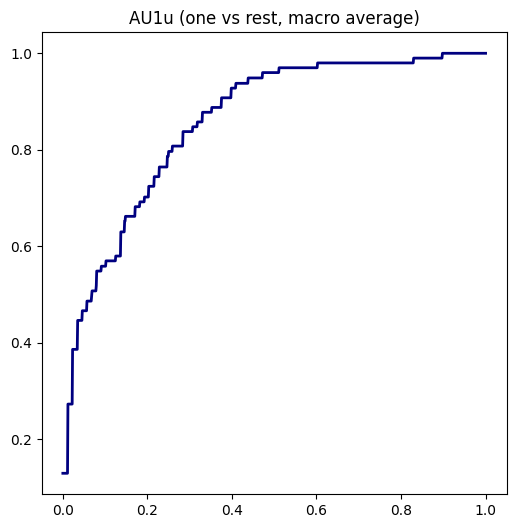

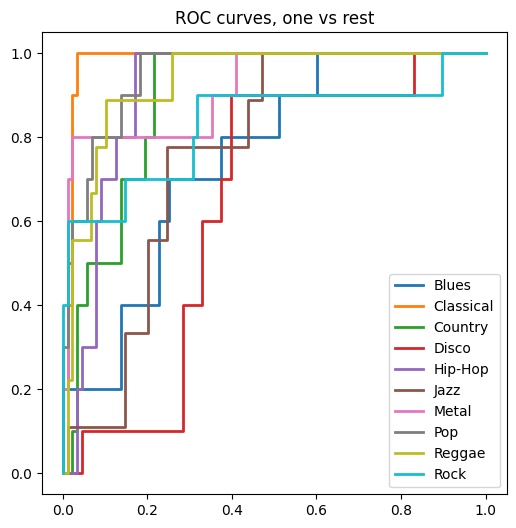

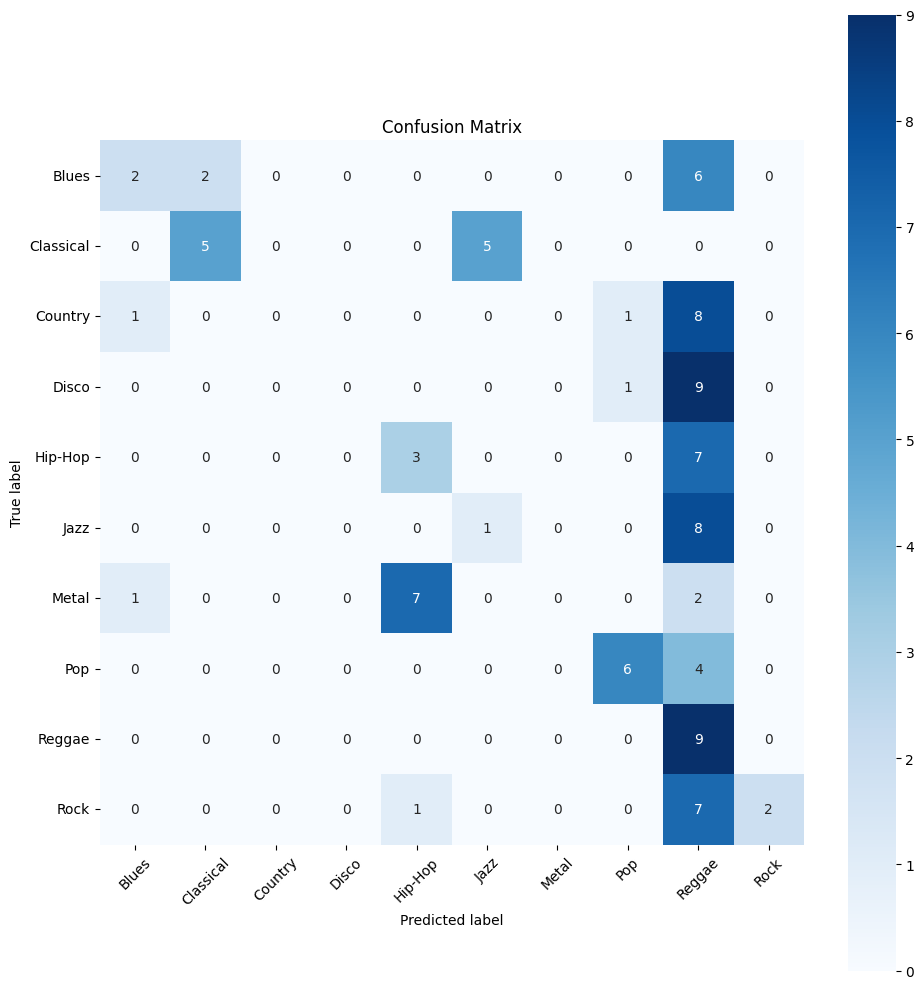

In [55]:
training_loop(model=model_gtzan,
              epochs=GTZAN_MULTI_EPOCHS,
              basic_metrics=gtzan_basic_multiclass_metrics,
              class_names=gtzan_classes,
              train_dl=gtzan_train_dl,
              val_dl=gtzan_val_dl,
              full_metrics=gtzan_full_multiclass_metrics)

GTZAN_MULTI_TOTAL_EPOCHS += GTZAN_MULTI_EPOCHS

        [3],
        [6],
        [9]], device='cuda:0') classes have zero instances in both the predictions and the ground truth labels. Precision is still logged as zero.
C:\Users\Operator\AppData\Local\Temp\ipykernel_15516\1215925936.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(cohens_kappa).to(self.device)
C:\Users\Operator\AppData\Local\Temp\ipykernel_15516\2229845795.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_names))


macro_accuracy: 0.8440
micro_accuracy: 0.8440
accuracy_per_class:
	Blues: 0.8300, Classical: 0.9200, Country: 0.9000, Disco: 0.9000, Hip-Hop: 0.8100, Jazz: 0.8400, Metal: 0.9000, Pop: 0.9200, Reggae: 0.5200, Rock: 0.9000, 
macro_f1: 0.1639
micro_f1: 0.2200
f1_per_class:
	Blues: 0.1053, Classical: 0.3333, Country: 0.0000, Disco: 0.0000, Hip-Hop: 0.2400, Jazz: 0.1111, Metal: 0.0000, Pop: 0.5556, Reggae: 0.2941, Rock: 0.0000, 
macro_precision: 0.2234
micro_precision: 0.2200
precision_per_class:
	Blues: 0.1111, Classical: 1.0000, Country: 0.0000, Disco: 0.0000, Hip-Hop: 0.2000, Jazz: 0.1250, Metal: 0.0000, Pop: 0.6250, Reggae: 0.1724, Rock: 0.0000, 
macro_recall: 0.2200
micro_recall: 0.2200
recall_per_class:
	Blues: 0.1000, Classical: 0.2000, Country: 0.0000, Disco: 0.0000, Hip-Hop: 0.3000, Jazz: 0.1000, Metal: 0.0000, Pop: 0.5000, Reggae: 1.0000, Rock: 0.0000, 
Cohen's Kappa: 0.1333
MCC: 0.1607
MSE: 0.1041
LogLoss: 3.1173
AUNu: 0.8396
AUNp: 0.8396
AU1u: 0.8396
AU1p: 0.8396
ROC-AUC_per_cla

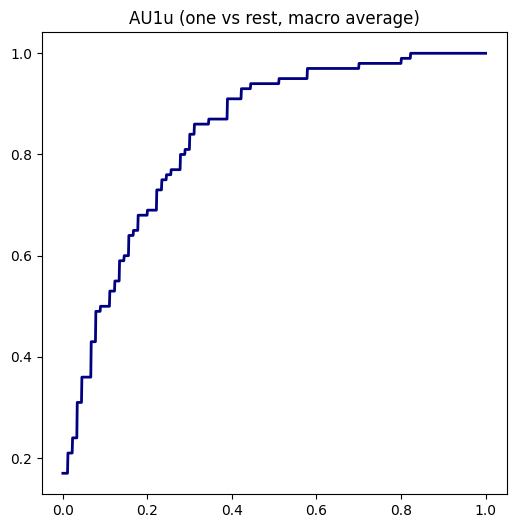

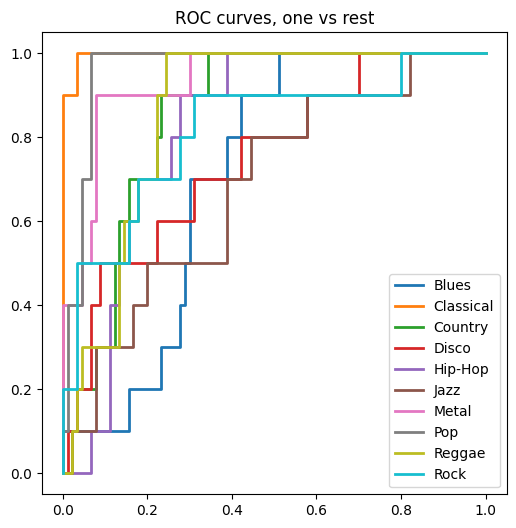

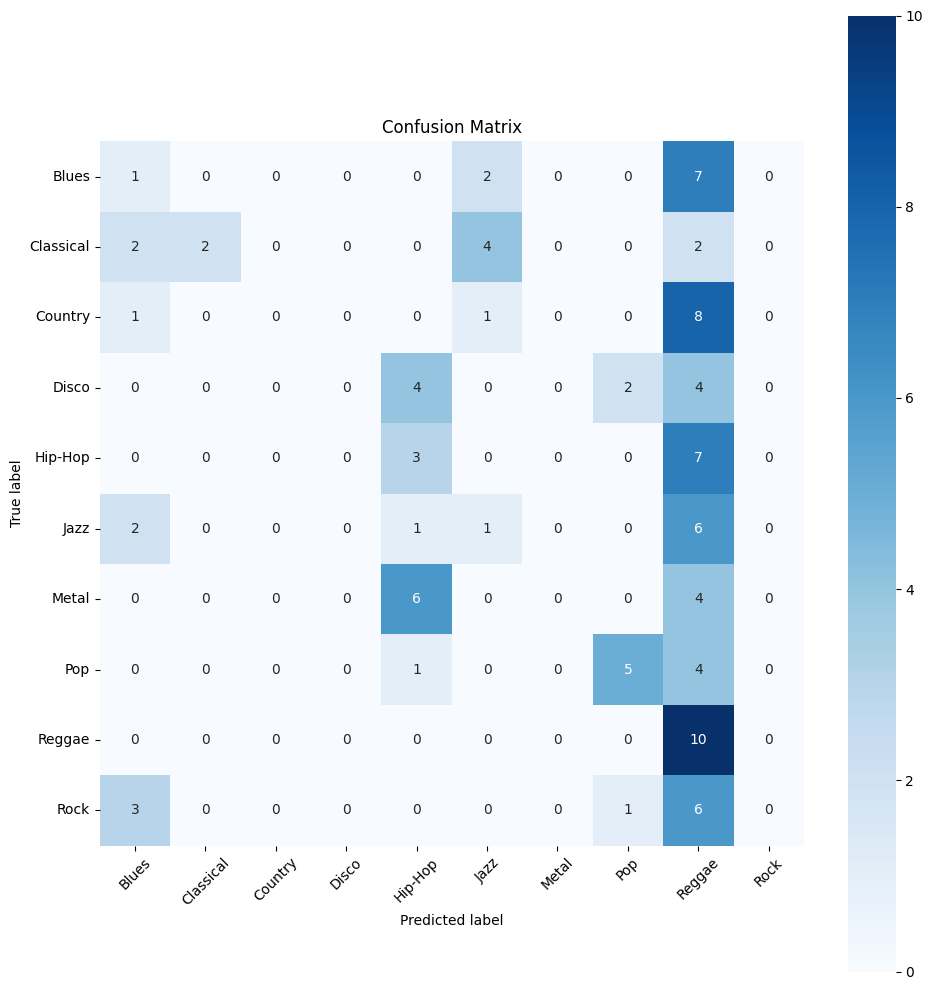

In [56]:
results = test_loop(model_gtzan, gtzan_full_multiclass_metrics, gtzan_classes, gtzan_test_dl)

Different micro and macro when a class has, for example, no TP in precision TP/(TP+FP)

Macro DOES count the 0, micro does not

Example:

(0.75+0.6+0.5714+0+0.3889+0.6154+0.75+0.7143+0.667+0.2727)/10 = 0.53297

(0.75+0.6+0.5714+0.3889+0.6154+0.75+0.7143+0.667+0.2727)/9 = 0.592

C:\Users\Operator\AppData\Local\Temp\ipykernel_15516\2229845795.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(class_names))


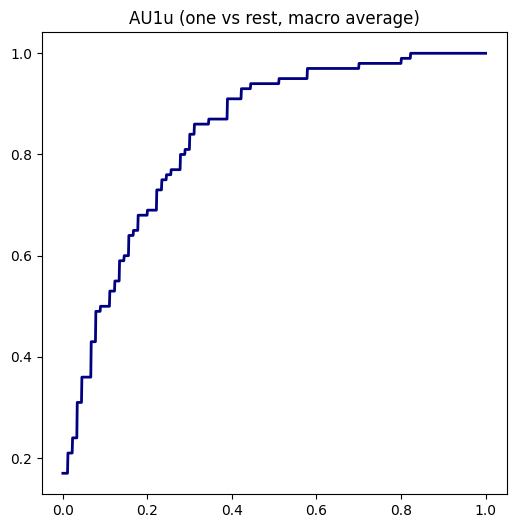

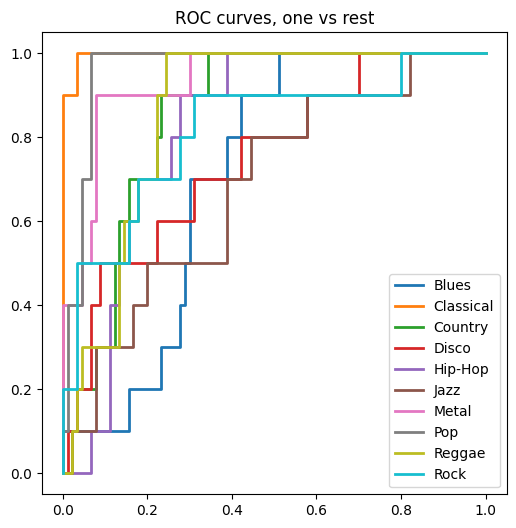

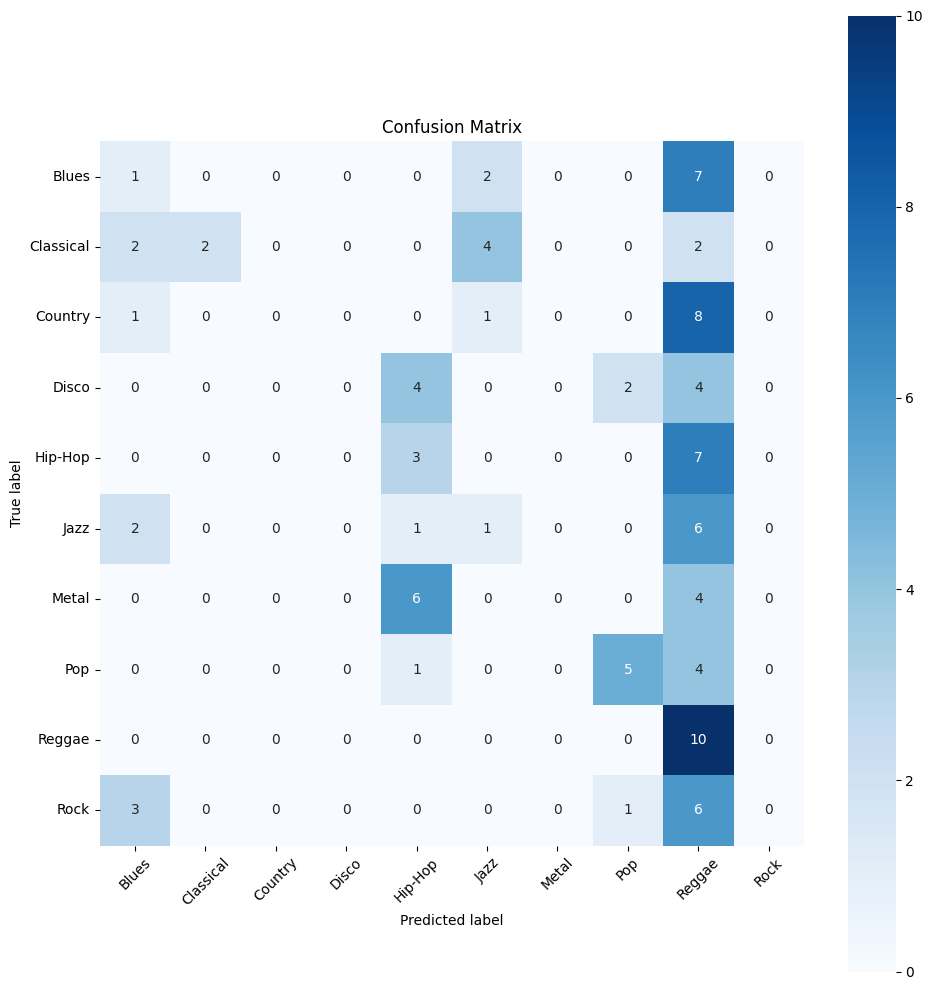

In [57]:
write_results_report_to_new_file(output_dir_path=report_output_dirs['gtzan_multi'],
                                 experiment_info=gtzan_multi_exp_info,
                                 epochs=GTZAN_MULTI_TOTAL_EPOCHS,
                                 results=results)

# Create FMA-small DataLoaders

In [39]:
BATCH_SIZE = 32
CHANNELS = 3

In [ ]:
# With val
fma_small_train_dl = prepare_dataloader_based_on_df(fma_small_train_df, fma_small_top_classes, BATCH_SIZE, CHANNELS)
fma_small_val_dl = prepare_dataloader_based_on_df(fma_small_val_df, fma_small_top_classes, BATCH_SIZE, CHANNELS)
fma_small_test_dl = prepare_dataloader_based_on_df(fma_small_test_df, fma_small_top_classes, BATCH_SIZE, CHANNELS)

In [ ]:
# Without val
fma_small_train_dl = prepare_dataloader_based_on_df(fma_small_train_df, fma_small_top_classes, BATCH_SIZE, CHANNELS)
fma_small_test_dl = prepare_dataloader_based_on_df(fma_small_test_df, fma_small_top_classes, BATCH_SIZE, CHANNELS)

# Create and train FMA-small model

In [ ]:
fma_small_multi_model_name = "model6"
fma_small_multi_test_set = "test"

In [ ]:
fma_small_multi_exp_info = experiment_info(fma_small_multi_model_name,
                                            "fma_small",
                                            "multi",
                                            fma_small_multi_test_set,
                                            fma_small_top_classes)

In [86]:
FMA_SMALL_MULTI_EPOCHS = 1
FMA_SMALL_MULTI_TOTAL_EPOCHS = 0

In [95]:
model_fma_small = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=len(fma_small_top_classes)).to(device)

In [75]:
fma_small_basic_multiclass_metrics = create_basic_multiclass_metrics(num_classes=len(fma_small_top_classes))
fma_small_full_multiclass_metrics = create_full_multiclass_metrics(num_classes=len(fma_small_top_classes))

In [ ]:
training_loop(model=model_fma_small,
              epochs=FMA_SMALL_MULTI_EPOCHS,
              basic_metrics=fma_small_basic_multiclass_metrics,
              class_names=fma_small_top_classes,
              train_dl=fma_small_train_dl,
              val_dl=fma_small_val_dl,
              full_metrics=fma_small_full_multiclass_metrics)

FMA_SMALL_MULTI_TOTAL_EPOCHS += FMA_SMALL_MULTI_EPOCHS

In [ ]:
results_fma_small = test_loop(model_fma_small, fma_small_full_multiclass_metrics, fma_small_top_classes, fma_small_test_dl)

In [ ]:
write_results_report_to_new_file(output_dir_path=report_output_dirs['fma_small_multi'],
                                 experiment_info=fma_small_multi_exp_info,
                                 epochs=FMA_SMALL_MULTI_TOTAL_EPOCHS,
                                 results=results_fma_small)

# Create FMA-medium DataLoaders

With val

In [42]:
BATCH_SIZE = 32
CHANNELS = 3

In [ ]:
# With val
fma_medium_train_dl = prepare_dataloader_based_on_df(fma_medium_train_df, fma_medium_top_classes, BATCH_SIZE, CHANNELS)
fma_medium_val_dl = prepare_dataloader_based_on_df(fma_medium_val_df, fma_medium_top_classes, BATCH_SIZE, CHANNELS)
fma_medium_test_dl = prepare_dataloader_based_on_df(fma_medium_test_df, fma_medium_top_classes, BATCH_SIZE, CHANNELS)

In [ ]:
# Without val
fma_medium_train_dl = prepare_dataloader_based_on_df(fma_medium_train_df, fma_medium_top_classes, BATCH_SIZE, CHANNELS)
fma_medium_test_dl = prepare_dataloader_based_on_df(fma_medium_test_df, fma_medium_top_classes, BATCH_SIZE, CHANNELS)

# Create and train FMA-medium model

In [ ]:
fma_medium_multi_model_name = "model6"
fma_medium_multi_test_set = "test"

In [ ]:
fma_medium_multi_exp_info = experiment_info(fma_medium_multi_model_name,
                                            "fma_medium",
                                            "multi",
                                            fma_medium_multi_test_set,
                                            fma_medium_top_classes)

In [99]:
FMA_MEDIUM_MULTI_EPOCHS = 5
FMA_MEDIUM_MULTI_TOTAL_EPOCHS = 0

In [94]:
model_fma_medium = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=len(fma_medium_top_classes)).to(device)

In [95]:
fma_medium_basic_multiclass_metrics = create_basic_multiclass_metrics(num_classes=len(fma_medium_top_classes))
fma_medium_full_multiclass_metrics = create_full_multiclass_metrics(num_classes=len(fma_medium_top_classes))

In [ ]:
training_loop(model=model_fma_medium,
              epochs=FMA_MEDIUM_MULTI_EPOCHS,
              basic_metrics=fma_medium_basic_multiclass_metrics,
              class_names=fma_medium_top_classes,
              train_dl=fma_medium_train_dl,
              val_dl=fma_medium_val_dl,
              full_metrics=fma_medium_full_multiclass_metrics)

FMA_MEDIUM_MULTI_TOTAL_EPOCHS += FMA_MEDIUM_MULTI_EPOCHS

In [ ]:
results_fma_medium = test_loop(model_fma_medium, fma_medium_full_multiclass_metrics, fma_medium_top_classes, fma_medium_test_dl)

In [ ]:
write_results_report_to_new_file(output_dir_path=report_output_dirs['fma_medium_multi'],
                                 experiment_info=fma_medium_multi_exp_info,
                                 epochs=FMA_MEDIUM_MULTI_TOTAL_EPOCHS,
                                 results=results_fma_medium)

# Function definition for binary classification

In [36]:
def trim_dataframe_to_binary_classification(df, class1, class2):
    return df[(df['genre'] == class1) | (df['genre'] == class2)]

# GTZAN binary classification

Best classes: Classical, Pop

In [ ]:
gtzan_binary_model_name = "model6"
gtzan_binary_test_set = "test"

In [ ]:
GTZAN_CLASS_1 = 'Classical' # Jazz
GTZAN_CLASS_2 = 'Metal'
gtzan_binary_classes = [GTZAN_CLASS_1, GTZAN_CLASS_2]

In [ ]:
gtzan_binary_exp_info = experiment_info(gtzan_binary_model_name,
                                        "gtzan",
                                        "binary",
                                        gtzan_binary_test_set,
                                        gtzan_binary_classes)

In [97]:
GTZAN_BINARY_EPOCHS = 5
GTZAN_BINARY_TOTAL_EPOCHS = 0

In [43]:
BATCH_SIZE = 32
CHANNELS = 3

In [45]:
gtzan_binary_train_df = trim_dataframe_to_binary_classification(gtzan_train_df, *gtzan_binary_classes)
gtzan_binary_val_df = trim_dataframe_to_binary_classification(gtzan_val_df,  *gtzan_binary_classes)
gtzan_binary_test_df = trim_dataframe_to_binary_classification(gtzan_test_df,  *gtzan_binary_classes)

In [ ]:
gtzan_binary_train_dl = prepare_dataloader_based_on_df(gtzan_binary_train_df, gtzan_binary_classes, BATCH_SIZE, CHANNELS)
gtzan_binary_val_dl = prepare_dataloader_based_on_df(gtzan_binary_val_df, gtzan_binary_classes, BATCH_SIZE, CHANNELS)
gtzan_binary_test_dl = prepare_dataloader_based_on_df(gtzan_binary_test_df, gtzan_binary_classes, BATCH_SIZE, CHANNELS)

In [47]:
model_gtzan_binary = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=1).to(device)

In [48]:
basic_metrics_binary = create_basic_binary_metrics()
full_metrics_binary = create_full_binary_metrics()

In [ ]:
training_loop(model=model_gtzan_binary,
              epochs=GTZAN_BINARY_EPOCHS,
              basic_metrics=basic_metrics_binary,
              class_names=gtzan_binary_classes,
              train_dl=gtzan_binary_train_dl,
              val_dl=gtzan_binary_val_dl,
              full_metrics=full_metrics_binary)

GTZAN_BINARY_TOTAL_EPOCHS += GTZAN_BINARY_EPOCHS

In [ ]:
results_gtzan_binary = test_loop(model_gtzan_binary, full_metrics_binary, gtzan_binary_classes, gtzan_binary_test_dl)

In [ ]:
write_results_report_to_new_file(output_dir_path=report_output_dirs['gtzan_binary'],
                                 experiment_info=gtzan_binary_exp_info,
                                 epochs=GTZAN_BINARY_TOTAL_EPOCHS,
                                 results=results_gtzan_binary)

# FMA-small binary classification

In [ ]:
fma_small_binary_model_name = "model6"
fma_small_binary_test_set = "test"

In [58]:
FMA_SMALL_BINARY_EPOCHS = 5
FMA_SMALL_BINARY_TOTAL_EPOCHS = 0

In [43]:
BATCH_SIZE = 32
CHANNELS = 3

In [44]:
FMA_SMALL_CLASS_1 = 'Electronic' # International
FMA_SMALL_CLASS_2 = 'Hip-Hop'
fma_small_binary_classes = [FMA_SMALL_CLASS_1, FMA_SMALL_CLASS_2]

In [ ]:
fma_small_binary_exp_info = experiment_info(fma_small_binary_model_name,
                                            "fma_small",
                                            "binary",
                                            fma_small_binary_test_set,
                                            fma_small_binary_classes)

In [ ]:
fma_small_binary_train_df = trim_dataframe_to_binary_classification(fma_small_train_df, *fma_small_binary_classes)
fma_small_binary_val_df = trim_dataframe_to_binary_classification(fma_small_val_df,  *fma_small_binary_classes)
fma_small_binary_test_df = trim_dataframe_to_binary_classification(fma_small_test_df,  *fma_small_binary_classes)

In [46]:
fma_small_binary_train_dl = prepare_dataloader_based_on_df(fma_small_binary_train_df, fma_small_binary_classes, BATCH_SIZE, CHANNELS)
fma_small_binary_val_dl = prepare_dataloader_based_on_df(fma_small_binary_val_df, fma_small_binary_classes, BATCH_SIZE, CHANNELS)
fma_small_binary_test_dl = prepare_dataloader_based_on_df(fma_small_binary_test_df, fma_small_binary_classes, BATCH_SIZE, CHANNELS)

In [55]:
model_fma_small_binary = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=1).to(device)

In [48]:
basic_metrics_binary = create_basic_binary_metrics()
full_metrics_binary = create_full_binary_metrics()

In [ ]:
training_loop(model=model_fma_small_binary,
              epochs=FMA_SMALL_BINARY_EPOCHS,
              basic_metrics=basic_metrics_binary,
              class_names=fma_small_binary_classes,
              train_dl=fma_small_binary_train_dl,
              val_dl=fma_small_binary_val_dl,
              full_metrics=full_metrics_binary)

FMA_SMALL_BINARY_TOTAL_EPOCHS += FMA_SMALL_BINARY_EPOCHS

In [ ]:
results_fma_small_binary = test_loop(model_fma_small_binary, full_metrics_binary, fma_small_binary_classes, fma_small_binary_test_dl)

In [ ]:
write_results_report_to_new_file(output_dir_path=report_output_dirs['fma_small_binary'],
                                 experiment_info=fma_small_binary_exp_info,
                                 epochs=FMA_SMALL_BINARY_TOTAL_EPOCHS,
                                 results=results_fma_small_binary)

# FMA-medium binary classification

In [ ]:
fma_medium_binary_model_name = "model6"
fma_medium_binary_test_set = "test"

In [54]:
FMA_MEDIUM_BINARY_EPOCHS = 5
FMA_MEDIUM_BINARY_TOTAL_EPOCHS = 0

In [38]:
BATCH_SIZE = 32
CHANNELS = 3

In [39]:
FMA_MEDIUM_CLASS_1 = 'Electronic'
FMA_MEDIUM_CLASS_2 = 'Rock'
fma_medium_binary_classes = [FMA_MEDIUM_CLASS_1, FMA_MEDIUM_CLASS_2]

In [ ]:
fma_medium_binary_exp_info = experiment_info(fma_medium_binary_model_name,
                                            "fma_medium",
                                            "binary",
                                            fma_medium_binary_test_set,
                                            fma_medium_binary_classes)

In [40]:
fma_medium_binary_train_df = trim_dataframe_to_binary_classification(fma_medium_train_df, *fma_medium_binary_classes)
fma_medium_binary_val_df = trim_dataframe_to_binary_classification(fma_medium_val_df,  *fma_medium_binary_classes)
fma_medium_binary_test_df = trim_dataframe_to_binary_classification(fma_medium_test_df,  *fma_medium_binary_classes)

In [49]:
fma_medium_binary_train_dl = prepare_dataloader_based_on_df(fma_medium_binary_train_df, fma_medium_binary_classes, BATCH_SIZE, CHANNELS)
fma_medium_binary_val_dl = prepare_dataloader_based_on_df(fma_medium_binary_val_df, fma_medium_binary_classes, BATCH_SIZE, CHANNELS)
fma_medium_binary_test_dl = prepare_dataloader_based_on_df(fma_medium_binary_test_df, fma_medium_binary_classes, BATCH_SIZE, CHANNELS)

In [50]:
model_fma_medium_binary = CNN(img_size=IMAGE_SIZE, channels=CHANNELS, num_outputs=1).to(device)

In [51]:
basic_metrics_binary = create_basic_binary_metrics()
full_metrics_binary = create_full_binary_metrics()

In [ ]:
training_loop(model=model_fma_medium_binary,
              epochs=FMA_MEDIUM_BINARY_EPOCHS,
              basic_metrics=basic_metrics_binary,
              class_names=fma_medium_binary_classes,
              train_dl=fma_medium_binary_train_dl,
              val_dl=fma_medium_binary_val_dl,
              full_metrics=full_metrics_binary)

FMA_MEDIUM_BINARY_TOTAL_EPOCHS += FMA_MEDIUM_BINARY_EPOCHS

In [ ]:
results_fma_medium_binary = test_loop(model_fma_medium_binary, full_metrics_binary, fma_medium_binary_classes, fma_medium_binary_test_dl)

In [ ]:
write_results_report_to_new_file(output_dir_path=report_output_dirs['fma_medium_binary'],
                                 experiment_info=fma_medium_binary_exp_info,
                                 epochs=FMA_MEDIUM_BINARY_TOTAL_EPOCHS,
                                 results=results_fma_medium_binary)